# Object Detection

Back in [chapter2](./02-more.ipynb), edge detection and Gaussian filtering was
explored to smooth an image and find edges. These operations can be combined
within the **canny** edge detection algorithm by tuning the `sigma` parameter.
Higher `sigma` values applies a higher intensity gaussian filter, removing
noise from an image prior to detecting edges.

`canny` requires a 2D ndarray (grayscale image).

In [1]:
from skimage import data
from skimage.feature import canny, corner_harris, corner_peaks, Cascade
from skimage.color import rgb2gray
from skimage.filters import gaussian # privacy preservation
import matplotlib.pyplot as plt
from matplotlib import patches # for plotting faces
import warnings

In [2]:
astro = data.astronaut()
astro_gray = rgb2gray(astro)
canny_astro_standard = canny(astro_gray)
canny_astro_low_sigma = canny(astro_gray, sigma=0.3)
canny_astro_high_sigma = canny(astro_gray, sigma=1.8)

Text(0.5, 1.0, 'sigma=1.8')

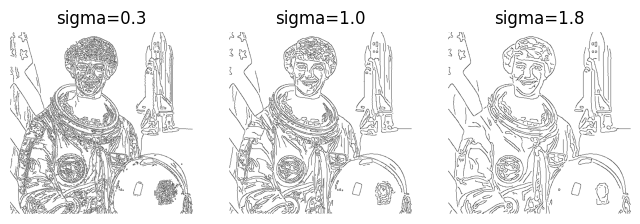

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8,6), sharex=True, sharey=True)
ax1.imshow(canny_astro_low_sigma, cmap="gray_r")
ax1.axis("off")
ax1.set_title("sigma=0.3")
ax2.imshow(canny_astro_standard, cmap="gray_r")
ax2.axis("off")
ax2.set_title("sigma=1.0")
ax3.imshow(canny_astro_high_sigma, cmap="gray_r")
ax3.axis("off")
ax3.set_title("sigma=1.8")

## Corner Detection
***

Points of interest in an image are robust, reliable features. This means that
they are largely unaffacted by scaling, orientation etc. Edges are just one
example of a point of interest in an image. We can also look for corners
between lines or curves.


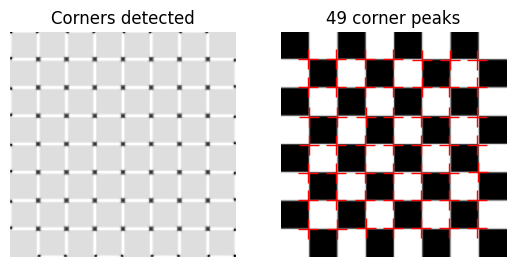

In [4]:
chess = data.checkerboard()
poss_corners = corner_harris(chess)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
ax1.imshow(poss_corners, cmap="Greys")
ax1.axis("off")
ax1.set_title("Corners detected")

corner_coords = corner_peaks(poss_corners, min_distance=20)
ax2.imshow(chess, cmap="Greys")
ax2.plot(corner_coords[:,1], corner_coords[:,0], "+r", markersize=15)
ax2.axis("off")
ax2.set_title(f"{len(corner_coords)} corner peaks")
plt.show()

## Face Detection
***

Face detection will use `skimage.feature.Cascade`, which is a collection of 
image classifiers. It needs to be instantiated on trained data, which is
available within the `skimage.data` module.

Note that a breaking change in the numpy behaviour is flagged in the below
cell. This has been patched in a newerv version of skimage.

In [5]:
trained_faces = data.lbp_frontal_face_cascade_filename()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    face_finder = Cascade(trained_faces)

In [6]:
found_face = face_finder.detect_multi_scale(
    astro, scale_factor=1.2,
    step_ratio=1.5,
    min_size=(10,10),
    max_size=(200,200)
    )
found_face
# 'r' and `c` give you the row and column pixel coordinate of the top left
# corner of the detected face. A list i sreturned in case of multiple faces.


[{'r': 74, 'c': 175, 'width': 93, 'height': 93}]

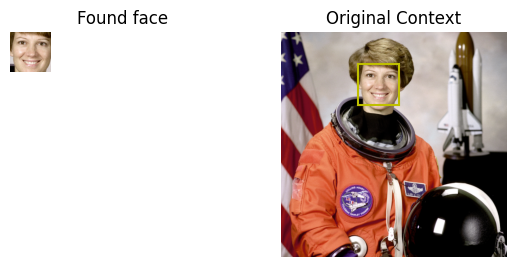

In [7]:
f = found_face[0] # only one face in this image
# get face bounds
face = astro[f["r"]:f["r"] + f["width"], f["c"]:f["c"] + f["height"]]

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
ax1.imshow(face, cmap="gray")
ax1.set_title("Found face")
ax1.axis("off")

# show found face
face_panel = plt.gca()
for patch in found_face:
    face_panel.add_patch(
        patches.Rectangle(
            (patch["c"], patch["r"]),
            patch["width"],
            patch["height"],
            fill=False,
            color="y",
            linewidth=1.5
        )
    )
ax2.imshow(astro, cmap="gray")

ax2.set_title("Original Context")
ax2.axis("off")


plt.show()

## Privacy Preservation
***

This section will use the face detection algorithm in combination with gaussian
filtering in order to blur faces found in an image.

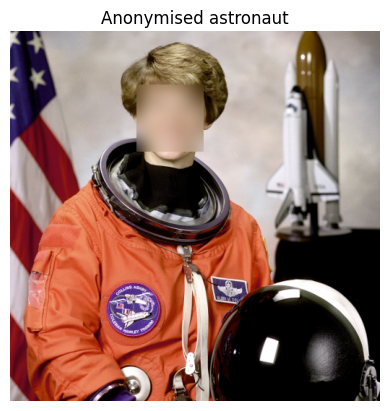

In [9]:
# have already found the face of the astronaut and saved as `found_face`
for f in found_face:
    # get rectangle around the face:
    x, y, w, h  = f["r"], f["c"], f["width"], f["height"]
    w = x + w
    h = y + h
    original_f = astro[x:w, y:h]
# apply gaussian filter. Need to specify preserve_range=True, as type
# conversion from int64 to int8 was rounding all 8s to 0, resulting in black box
blur_f = gaussian(original_f, multichannel=True, sigma=8, preserve_range=True)
# the blurred face needs to be superimposed on the original image
astro[x:w, y:h] = blur_f
plt.imshow(astro)
plt.axis("off")
plt.title("Anonymised astronaut")
plt.show()